# Visualizing corona case data with altair

In [1]:
import io
from functools import lru_cache

import altair as alt
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
data_url = "https://raw.githubusercontent.com/thohan88/covid19-nor-data/HEAD/data"


@lru_cache()
def download_dataset(path):
    """Download a dataset from covid19-nor-data archive"""
    url = f"{data_url}/{path}"
    print(f"Downloading {url}")
    r = requests.get(f"{data_url}/{path}")
    r.raise_for_status()
    print(f"Downloaded {len(r.content) // 1024}kB")
    if path.endswith(".csv"):
        read = pd.read_csv
    elif path.endswith(".xlsx"):
        read = pd.read_excel
    return read(io.BytesIO(r.content), parse_dates=["date"])


all_cases = download_dataset("01_infected/msis/municipality_and_district.csv")
all_cases

Downloaded 31065kB


,date,date_time,kommune_bydel_no,kommune_bydel_name,bydel_no,bydel_name,kommune_no,kommune_name,fylke_no,fylke_name,population,cases
0,2020-03-26,2020-03-26T04:00:00Z,30101,Gamle Oslo,30101.0,Gamle Oslo,301,Oslo,3,Oslo,58671,67
1,2020-03-26,2020-03-26T04:00:00Z,30102,Grünerløkka,30102.0,Grünerløkka,301,Oslo,3,Oslo,62423,59
2,2020-03-26,2020-03-26T04:00:00Z,30103,Sagene,30103.0,Sagene,301,Oslo,3,Oslo,45089,47
3,2020-03-26,2020-03-26T04:00:00Z,30104,St. Hanshaugen,30104.0,St. Hanshaugen,301,Oslo,3,Oslo,38945,33
4,2020-03-26,2020-03-26T04:00:00Z,30105,Frogner,30105.0,Frogner,301,Oslo,3,Oslo,59269,67
...,...,...,...,...,...,...,...,...,...,...,...,...
377250,2022-12-07,2022-12-07T04:00:00Z,5442,Nesseby,NaN,NaN,5442,Nesseby,54,Troms og Finnmark,926,88
377251,2022-12-07,2022-12-07T04:00:00Z,5443,Båtsfjord,NaN,NaN,5443,Båtsfjord,54,Troms og Finnmark,2221,447
377252,2022-12-07,2022-12-07T04:00:00Z,5444,Sør-Varanger,NaN,NaN,5444,Sør-Varanger,54,Troms og Finnmark,10158,1601
377253,2022-12-07,2022-12-07T04:00:00Z,9998,Svalbard,NaN,NaN,9998,Svalbard,99,Svalbard,0,0


In [3]:
# aggregate data by fylke
cases = (
    all_cases.groupby(["fylke_name", "date"])[["cases", "population"]]
    .sum()
    .reset_index()
).copy()
cases

,fylke_name,date,cases,population
0,Agder,2020-03-26,133,307231
1,Agder,2020-03-27,148,307231
2,Agder,2020-03-28,159,307231
3,Agder,2020-03-29,161,307231
4,Agder,2020-03-30,166,307231
...,...,...,...,...
12800,Viken,2022-12-03,393395,1241165
12801,Viken,2022-12-04,393399,1241165
12802,Viken,2022-12-05,393410,1241165
12803,Viken,2022-12-06,393463,1241165


In [4]:
# discard ukjent fylke where population 100k doesn't make sense
cases = cases[~cases.fylke_name.str.contains("Ukjent")].copy()
cases

,fylke_name,date,cases,population
0,Agder,2020-03-26,133,307231
1,Agder,2020-03-27,148,307231
2,Agder,2020-03-28,159,307231
3,Agder,2020-03-29,161,307231
4,Agder,2020-03-30,166,307231
...,...,...,...,...
12800,Viken,2022-12-03,393395,1241165
12801,Viken,2022-12-04,393399,1241165
12802,Viken,2022-12-05,393410,1241165
12803,Viken,2022-12-06,393463,1241165


In [5]:
# 'cases' is a cumulative sum
# reverse that to calculate the daily new case count

# 1. createe a new column
cases["daily cases"] = 0

# 2. populate it per fylke
for fylke in cases.fylke_name.unique():
    mask = cases.fylke_name == fylke
    fylke_cases = cases.loc[mask]
    diff = fylke_cases.cases.diff()
    # set first value from cases
    diff.iloc[0] = fylke_cases.iloc[0].cases
    cases.loc[fylke_cases.index, "daily cases"] = diff.astype(int)

cases

,fylke_name,date,cases,population,daily cases
0,Agder,2020-03-26,133,307231,133
1,Agder,2020-03-27,148,307231,15
2,Agder,2020-03-28,159,307231,11
3,Agder,2020-03-29,161,307231,2
4,Agder,2020-03-30,166,307231,5
...,...,...,...,...,...
12800,Viken,2022-12-03,393395,1241165,47
12801,Viken,2022-12-04,393399,1241165,4
12802,Viken,2022-12-05,393410,1241165,11
12803,Viken,2022-12-06,393463,1241165,53


# Add per-100,000 population column

In [6]:
# per100k is "daily new cases per 100k population"
cases["per100k"] = cases["daily cases"] * 1e5 / (cases["population"] + 1)
cases

,fylke_name,date,cases,population,daily cases,per100k
0,Agder,2020-03-26,133,307231,133,43.289761
1,Agder,2020-03-27,148,307231,15,4.882304
2,Agder,2020-03-28,159,307231,11,3.580356
3,Agder,2020-03-29,161,307231,2,0.650974
4,Agder,2020-03-30,166,307231,5,1.627435
...,...,...,...,...,...,...
12800,Viken,2022-12-03,393395,1241165,47,3.786762
12801,Viken,2022-12-04,393399,1241165,4,0.322278
12802,Viken,2022-12-05,393410,1241165,11,0.886263
12803,Viken,2022-12-06,393463,1241165,53,4.270178


## Exercise

plot cases per 1000 by fylke over time

In [7]:
latest_cases = cases[-5000:]

In [8]:
latest_cases.columns

Index(['fylke_name', 'date', 'cases', 'population', 'daily cases', 'per100k'], dtype='object')

In [9]:
subset = cases[cases.fylke_name.isin(["Oslo", "Viken"])]


daily = (
    alt.Chart(subset)
    .mark_point()
    .encode(
        x="date:T",
        y="per100k",
        color="fylke_name",
        tooltip=[
            "fylke_name",
            "population",
            "per100k",
            "cases",
        ],
    )
)
daily

alt.Chart(...)

In [10]:
weekly = (
    alt.Chart(subset)
    .mark_line()
    .transform_window(
        weekly_avg="mean(per100k)",
        frame=[-3, 3],
    )
    .encode(
        x="date:T",
        y="weekly_avg:Q",
        color="fylke_name",
        tooltip=[
            "fylke_name",
            "population",
            "per100k",
            "cases",
            "date",
        ],
    )
)
weekly

alt.Chart(...)

In [11]:
weekly | daily

alt.HConcatChart(...)

We can also do the same with matplotlib

fylke_name
Oslo     Axes(0.125,0.2;0.775x0.68)
Viken    Axes(0.125,0.2;0.775x0.68)
dtype: object

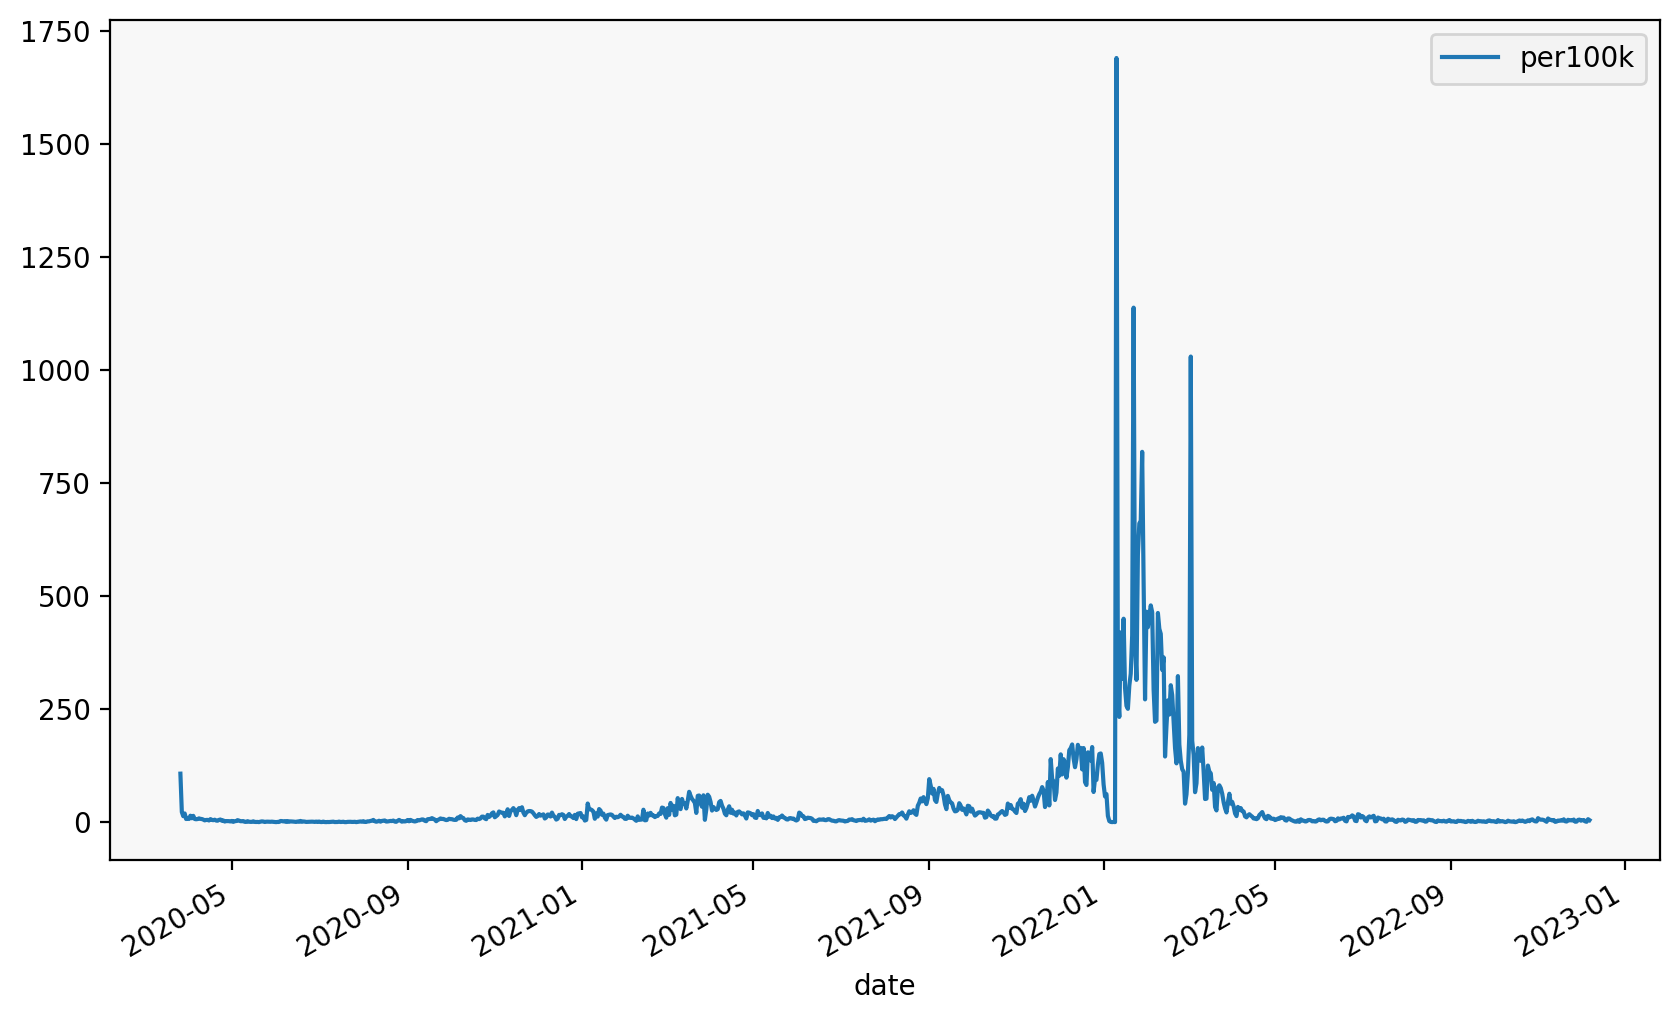

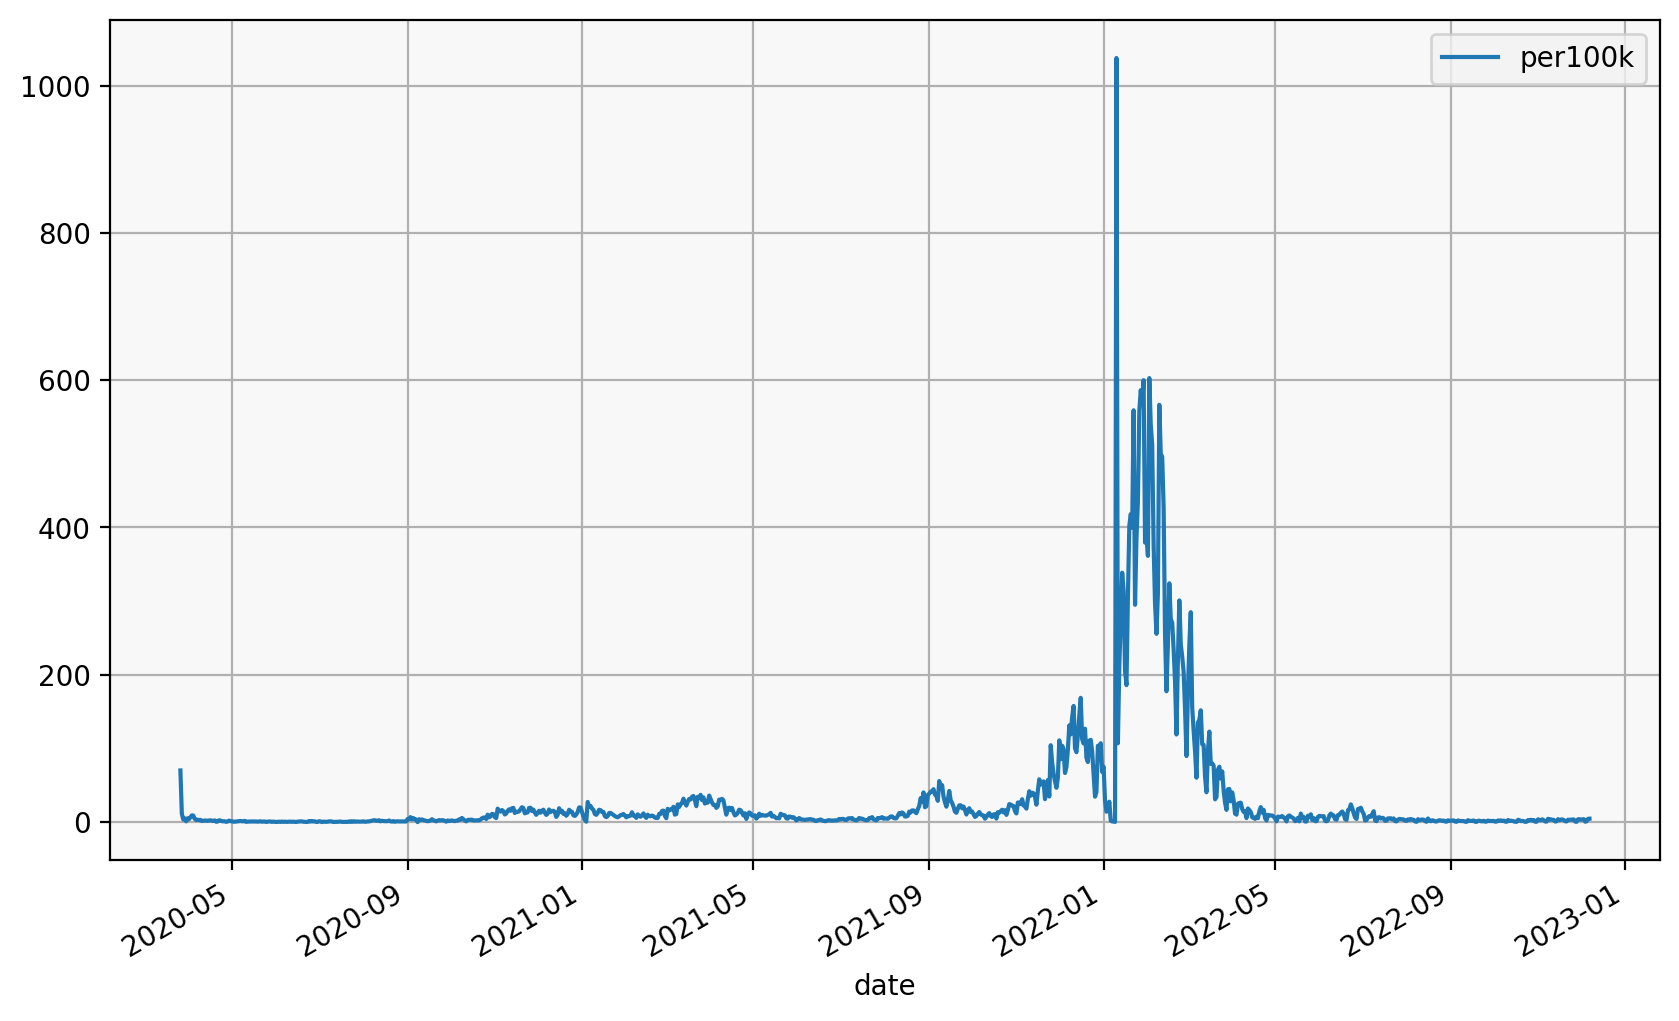

In [12]:
subset.groupby("fylke_name")[["date", "per100k"]].plot(
    x="date", y="per100k", legend=True
)

fylke_name
Oslo     Axes(0.125,0.2;0.775x0.68)
Viken    Axes(0.125,0.2;0.775x0.68)
Name: per100k, dtype: object

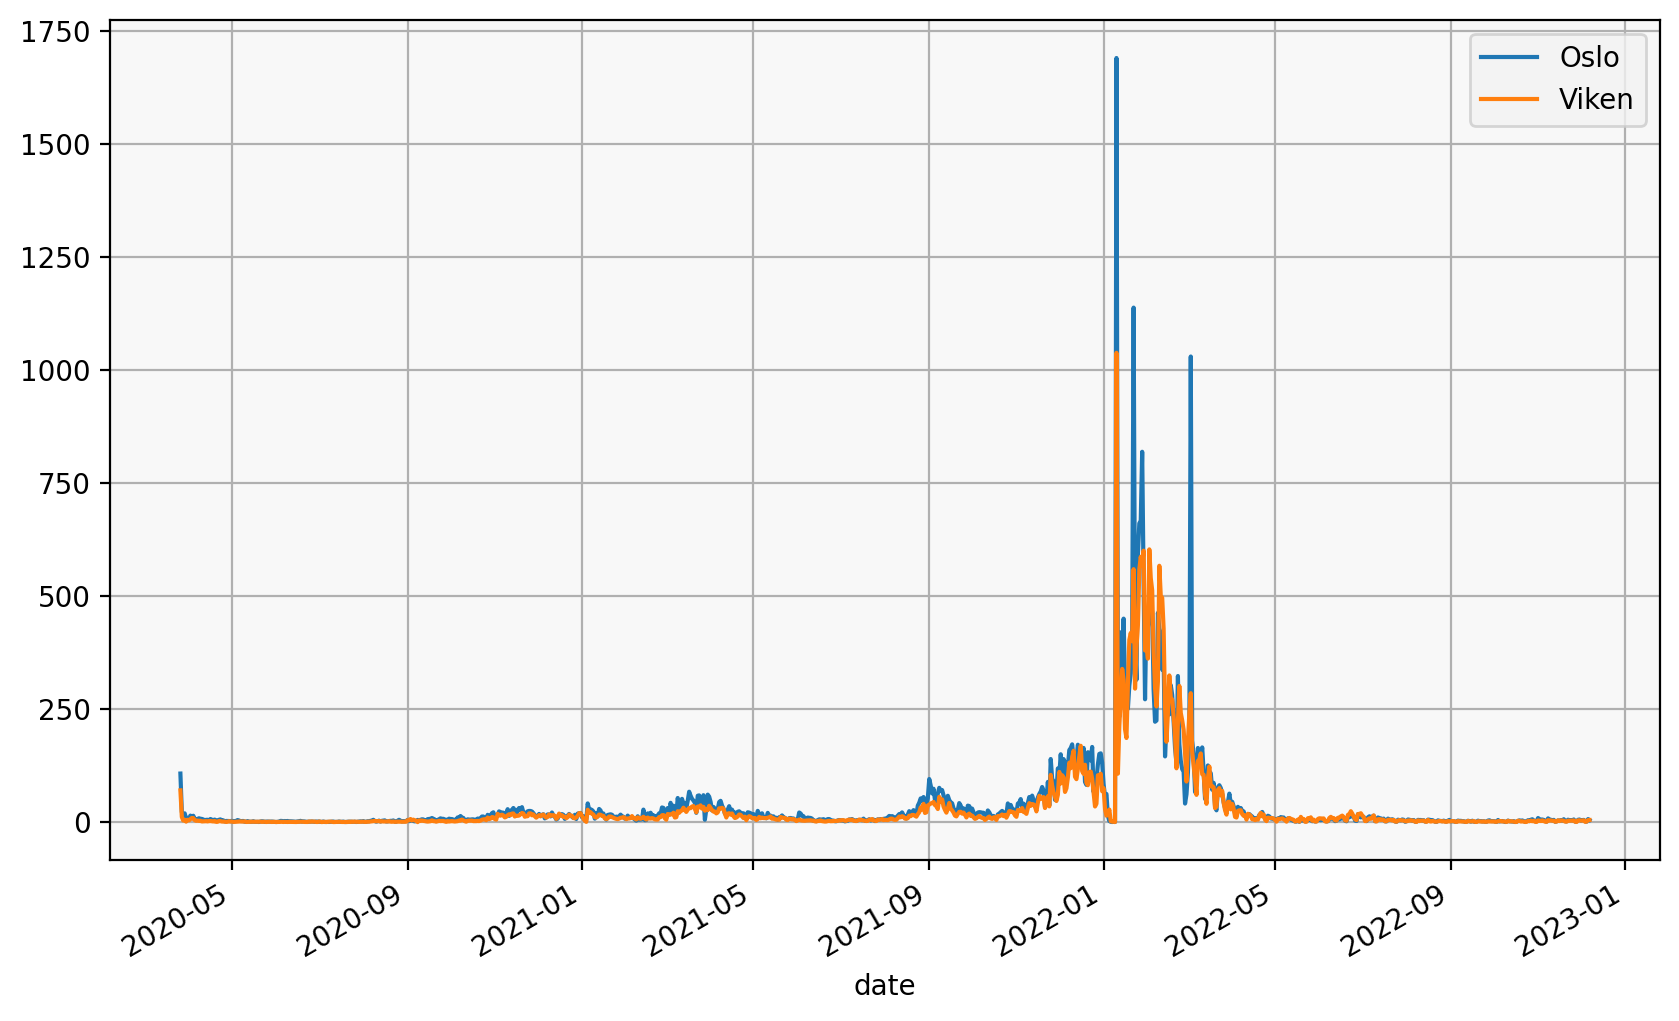

In [13]:
subset.set_index("date").groupby("fylke_name").per100k.plot(legend=True)

In [17]:
admissions = pd.read_csv(
    "pasienter-innlagt-i-syke.csv",
    parse_dates=["Dato"],
    dayfirst=True,
)
admissions

,Dato,Kumulativt antall,Nye sykehusinnlegelser
0,2020-02-21,0,0
1,2020-02-22,0,0
2,2020-02-23,0,0
3,2020-02-24,0,0
4,2020-02-25,0,0
...,...,...,...
973,2022-10-21,16348,13
974,2022-10-22,16359,11
975,2022-10-23,16374,15
976,2022-10-24,16389,15


In [18]:
alt.Chart(admissions).mark_line().encode(
    x="Dato",
    y="Nye sykehusinnlegelser:Q",
)

alt.Chart(...)

In [75]:
monthly_hospital = (
    alt.Chart(admissions)
    .mark_line()
    .transform_window(
        frame=[-30, 0],
        admissions="mean(Nye sykehusinnlegelser)",
    )
    .encode(
        x="Dato",
        y="admissions:Q",
    )
)

alt.vconcat(monthly_hospital, weekly)

alt.VConcatChart(...)

In [69]:
weekly

alt.Chart(...)